# Land Mask

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
from salishsea_tools import viz_tools
from salishsea_tools import geo_tools
from salishsea_tools import grid_tools
from salishsea_tools import utilities
%matplotlib inline
speed_cmap = cmocean.cm.speed

In [2]:
GEM = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1")  # HDPRC latlon
nemo_mask =xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02") # NEMO land mask
nemo_grid = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02") # NEMO lat lon

In [3]:
winddata = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1") # Contains wind data

In [4]:
def build_GEM_mask(grid_GEM, grid_NEMO, mask_NEMO):


    # Preallocate
    ngrid_GEM = grid_GEM['gridX'].shape[0] * grid_GEM['gridY'].shape[0]
    mask_GEM = np.zeros(ngrid_GEM, dtype=int)

    # Evaluate each point on GEM grid
    bar = utilities.statusbar('Building GEM mask', width=90, maxval=ngrid_GEM)
    for index, coords in enumerate(bar(zip(
            grid_GEM['longitude'].values.reshape(ngrid_GEM) - 360,
            grid_GEM['latitude'].values.reshape(ngrid_GEM),
    ))):

        j, i = geo_tools.find_closest_model_point(
            coords[0], coords[1],
            grid_NEMO['longitude'], grid_NEMO['latitude'],
        )
        if j is np.nan or i is np.nan:
            mask_GEM[index] = 0
        else:
            mask_GEM[index] = mask_NEMO[j, i].values

    # Reshape
    mask_GEM = mask_GEM.reshape(grid_GEM['longitude'].shape)

    return mask_GEM

In [5]:
land_mask = build_GEM_mask(GEM, nemo_grid, nemo_mask.tmaskutil.isel(time=0))

Building GEM mask 100% (68096 of 68096) |##################################|Time:  0:06:43


In [6]:
def mask_data(data, land_mask = land_mask):
    masked_data = ma.masked_array(data, np.logical_not(land_mask))  # mask the data
    remove_zero_rows = masked_data[~(masked_data==np.nan).all(1)]   # remove rows with only zero entries
    transpose_rows = np.transpose(remove_zero_rows)                 # transpose the resulting array
    remove_zero_cols = np.transpose(transpose_rows[~(transpose_rows==np.nan).all(1)])  # remove the column with only zero entries
    return remove_zero_cols

In [7]:
time_0_wind = mask_data(winddata.u_wind.isel(time=0).values)

/home/abhudia/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


1.1363636363636362

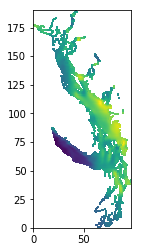

In [8]:
# plot with forced aspect ratio
fig, ax = plt.subplots(1,1)
ax.pcolormesh(time_0_wind)
viz_tools.set_aspect(ax)

In [9]:
winddata

<xarray.Dataset>
Dimensions:    (gridX: 256, gridY: 266, time: 37920)
Coordinates:
  * time       (time) datetime64[ns] 2014-09-12 ... 2019-01-08T23:00:00
  * gridY      (gridY) float64 0.0 2.5e+03 5e+03 ... 6.575e+05 6.6e+05 6.625e+05
  * gridX      (gridX) float64 0.0 2.5e+03 5e+03 ... 6.35e+05 6.375e+05
Data variables:
    atmpres    (time, gridY, gridX) float32 ...
    precip     (time, gridY, gridX) float32 ...
    qair       (time, gridY, gridX) float32 ...
    solar      (time, gridY, gridX) float32 ...
    tair       (time, gridY, gridX) float32 ...
    therm_rad  (time, gridY, gridX) float32 ...
    u_wind     (time, gridY, gridX) float32 ...
    v_wind     (time, gridY, gridX) float32 ...
Attributes:
    acknowledgement:           MEOPAR, ONC, Compute Canada, Environment Canada
    cdm_data_type:             Grid
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    coverage_content_type:     modelResult
    creator_email:             sallen@eos.ubc.ca
    creator_name:

# December winds

In [10]:
dec_data_u = winddata.u_wind.loc[winddata['time.month'].isin([12])]
dec_data_v = winddata.v_wind.loc[winddata['time.month'].isin([12])]
dec_wind_mag = xr.ufuncs.sqrt(dec_data_u**2+dec_data_v**2)

### Mean winds

Text(0, 0.5, 'Y')

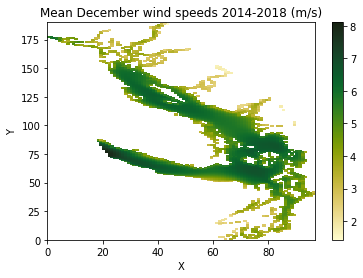

In [11]:
mean_dec = mask_data(dec_wind_mag.mean(dim='time').values)
plt.pcolormesh(mean_dec, cmap = speed_cmap)
plt.colorbar()
plt.title('Mean December wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Standard Deviation

Text(0, 0.5, 'Y')

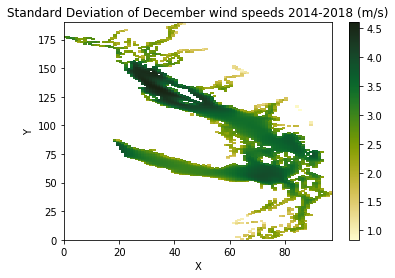

In [12]:
stddev_dec = mask_data(dec_wind_mag.std(dim='time').values)
plt.pcolormesh(stddev_dec, cmap = speed_cmap)
plt.colorbar()
plt.title('Standard Deviation of December wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Maximum winds

Text(0, 0.5, 'Y')

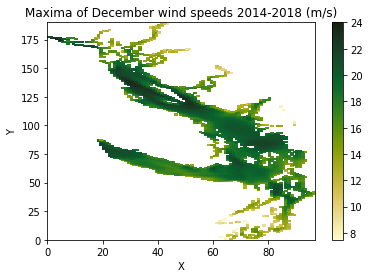

In [13]:
max_dec = mask_data(dec_wind_mag.max(dim='time').values)
plt.pcolormesh(max_dec, cmap = speed_cmap)
plt.colorbar()
plt.title('Maxima of December wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

# March winds

In [14]:
mar_data_u = winddata.u_wind.loc[winddata['time.month'].isin([3])]
mar_data_v = winddata.v_wind.loc[winddata['time.month'].isin([3])]
mar_wind_mag = xr.ufuncs.sqrt(mar_data_u**2+mar_data_v**2)

### Mean Winds

In [1]:
mean_mar = mask_data(mar_wind_mag.mean(dim='time').values)
plt.pcolormesh(mean_mar, cmap = speed_cmap)
plt.colorbar()
plt.title('Mean March wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

NameError: name 'mask_data' is not defined

### Standard Deviation

Text(0, 0.5, 'Y')

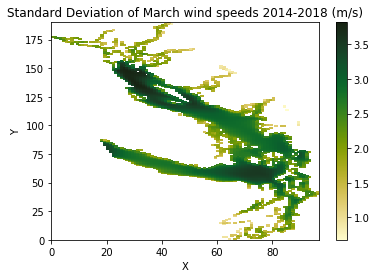

In [16]:
stddev_mar = mask_data(mar_wind_mag.std(dim='time').values)
plt.pcolormesh(stddev_mar, cmap = speed_cmap)
plt.colorbar()
plt.title('Standard Deviation of March wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Maximum Winds

Text(0, 0.5, 'Y')

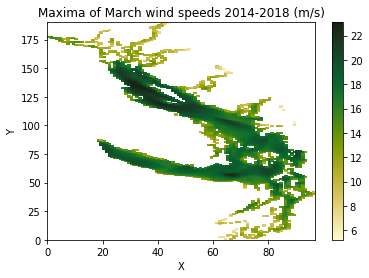

In [17]:
max_mar = mask_data(mar_wind_mag.max(dim='time').values)
plt.pcolormesh(max_mar, cmap = speed_cmap)
plt.colorbar()
plt.title('Maxima of March wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

# June Winds

In [18]:
june_data_u = winddata.u_wind.loc[winddata['time.month'].isin([6])]
june_data_v = winddata.v_wind.loc[winddata['time.month'].isin([6])]
june_wind_mag = xr.ufuncs.sqrt(june_data_u**2+june_data_v**2)

### Mean

Text(0, 0.5, 'Y')

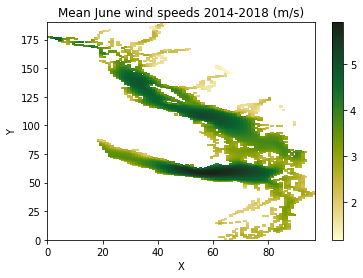

In [19]:
mean_june = mask_data(june_wind_mag.mean(dim='time').values)
plt.pcolormesh(mean_june, cmap = speed_cmap)
plt.colorbar()
plt.title('Mean June wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Standard Deviation

Text(0, 0.5, 'Y')

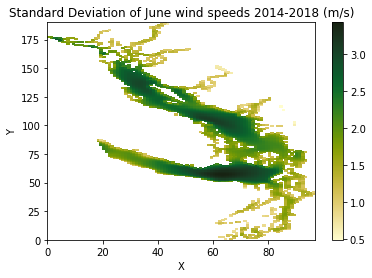

In [20]:
stddev_june = mask_data(june_wind_mag.std(dim='time').values)
plt.pcolormesh(stddev_june, cmap = speed_cmap)
plt.colorbar()
plt.title('Standard Deviation of June wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Maxima

Text(0, 0.5, 'Y')

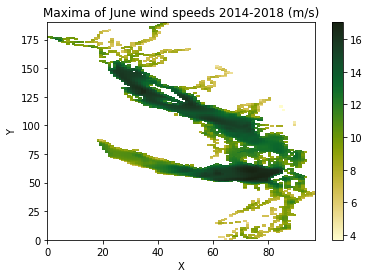

In [21]:
max_june = mask_data(june_wind_mag.max(dim='time').values)
plt.pcolormesh(max_june, cmap = speed_cmap)
plt.colorbar()
plt.title('Maxima of June wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

# September winds

In [22]:
sept_data_u = winddata.u_wind.loc[winddata['time.month'].isin([9])]
sept_data_v = winddata.v_wind.loc[winddata['time.month'].isin([9])]
sept_wind_mag = xr.ufuncs.sqrt(sept_data_u**2+sept_data_v**2)

### Mean

Text(0, 0.5, 'Y')

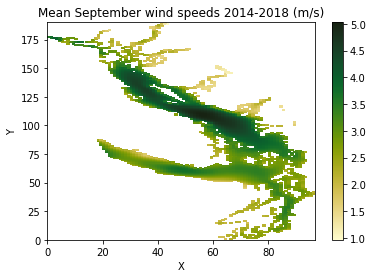

In [23]:
mean_sept= mask_data(sept_wind_mag.mean(dim='time').values)
plt.pcolormesh(mean_sept, cmap = speed_cmap)
plt.colorbar()
plt.title('Mean September wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Standard Deviation

Text(0, 0.5, 'Y')

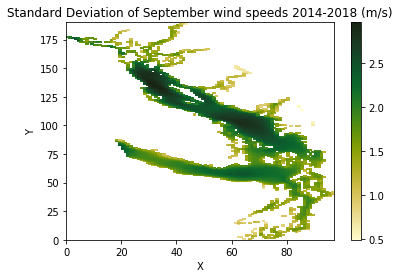

In [24]:
stddev_sept= mask_data(sept_wind_mag.std(dim='time').values)
plt.pcolormesh(stddev_sept, cmap = speed_cmap)
plt.colorbar()
plt.title('Standard Deviation of September wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Maxima

Text(0, 0.5, 'Y')

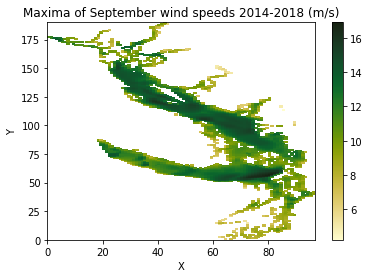

In [25]:
max_sept= mask_data(sept_wind_mag.max(dim='time').values)
plt.pcolormesh(max_sept, cmap = speed_cmap)
plt.colorbar()
plt.title('Maxima of September wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

# All Winds

In [42]:
all_wind_mag = dec_wind_mag 

for i in range(11):
    all_wind_mag  = np.append(all_wind_mag, xr.ufuncs.sqrt(winddata.u_wind.loc[winddata['time.month'].isin([i+1])]**2 + 
                                                               winddata.v_wind.loc[winddata['time.month'].isin([i+1])]**2) , axis = 0)
    print(i)   


0
1
2
3
4
5
6
7


MemoryError: 

### Mean

In [41]:
all_wind_mag.shape

(9600, 266, 256)

<xarray.DataArray (time: 0, gridY: 266, gridX: 256)>
array([], shape=(0, 266, 256), dtype=float64)
Coordinates:
  * time     (time) datetime64[ns] 
  * gridY    (gridY) float64 0.0 2.5e+03 5e+03 ... 6.575e+05 6.6e+05 6.625e+05
  * gridX    (gridX) float64 0.0 2.5e+03 5e+03 ... 6.325e+05 6.35e+05 6.375e+05

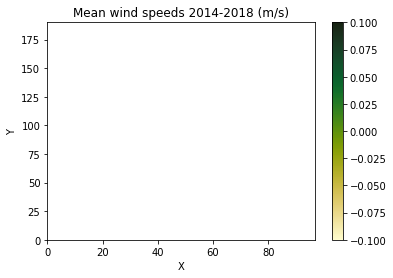

In [35]:
mean_all= mask_data(all_wind_mag.mean(dim='time').values)
plt.pcolormesh(mean_all, cmap = speed_cmap)
plt.colorbar()
plt.title('Mean wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')
all_wind_mag

### Standard Deviation

Text(0, 0.5, 'Y')

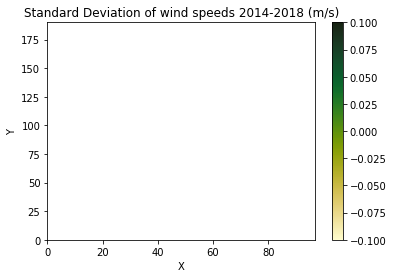

In [29]:
stddev_all = mask_data(all_wind_mag.std(dim='time').values)
plt.pcolormesh(stddev_all, cmap = speed_cmap)
plt.colorbar()
plt.title('Standard Deviation of wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

### Maxima

In [34]:
max_all = mask_data(all_wind_mag.max(dim='time').values)
plt.pcolormesh(max_all, cmap = speed_cmap)
plt.colorbar()
plt.title('Maxima of wind speeds 2014-2018 (m/s)')
plt.xlabel('X')
plt.ylabel('Y')

ValueError: numpy.nanmax raises on a.shape[axis]==0; So Bottleneck too.

# Percent Days

### Percent days with winds greater than 7 m/s

In [ ]:
sample = winddata.u_wind.isel(time=0).values  # sample to extract dimensions from
dim = sample.shape  # determine dimension of sample
time_steps = winddata.u_wind.time.size   # determine number of time steps
count_array_7 = np.zeros([dim[0],dim[1]])  # array of zeros used to count the days

for i in range(time_steps):
    percentdata = all_winds_mag.u_wind.isel(time=i).values  # for each time
    condlist = [percentdata > 7 , percentdata <= 7]     # see if this condition is met eg min wind speed 7
    choicelist = [1, 0]  # add one to the days if met, zero otherwise
    count_array_7 = count_array_7 + np.sum(np.select(condlist, choicelist), axis = 1)  # add the count to count array

count_array_7 = countarray_7 / time_steps * 100  # finally express this as percentages

In [ ]:
plt.pcolormesh(count_array_7, cmap = speed_cmap)
plt.colorbar()
plt.title('Percentage of days with wind speeds exceeding 7 m/s over 2014-2018')
plt.xlabel('X')
plt.ylabel('Y')

### Percent days with winds greater than 10 m/s

In [ ]:
count_array_10 = np.zeros([dim[0],dim[1]])  # array of zeros used to count the days

for i in range(time_steps):
    percentdata = all_winds_mag.u_wind.isel(time=i).values  # for each time
    condlist = [percentdata > 10 , percentdata <= 10]     # see if this condition is met eg min wind speed 7
    choicelist = [1, 0]  # add one to the days if met, zero otherwise
    count_array_10 = count_array_10 + np.sum(np.select(condlist, choicelist), axis = 1)  # add the count to count array

count_array_10 = countarray_10 / time_steps * 100  # finally express this as percentages

In [ ]:
plt.pcolormesh(count_array_10, cmap = speed_cmap)
plt.colorbar()
plt.title('Percentage of days with wind speeds exceeding 10 m/s over 2014-2018')
plt.xlabel('X')
plt.ylabel('Y')

In [44]:
import os
b = os.path.getsize("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1")

FileNotFoundError: [Errno 2] No such file or directory: 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1'

In [1]:
operations = ['mean', 'std', 'max']
a = '{}'.format(operations)

In [2]:
a

"['mean', 'std', 'max']"